1. This code for performing DMD on OLR which is the major proxy for MJO (MAdden Julian Oscillations)
2. Reading OLR data on 2.5x2.5 degree latxlon grid for the period of 01 Jan 2010 to 31 Dec 2013 ( Four years)
3. To Separate MJO signals from OLR lanczos_bandpass filter function is used i.e, 30 to 90 days period
4. Then standard DMD is performed and dominant feature are captured 
5. Then reconstrucuted and error metrics are calculated
6. Then forecast is done for next seven days

In [1]:
import xarray as xr
import numpy as np
from scipy.linalg import svd, eig
import matplotlib.pyplot as plt


Here sample calulations are done

NOTE: For sample calulation r=300 is used. Optimal r is found below

Although optimal rank is found to be 244 in below i am using r=300 which caputures almost all the
energy (out of 1460 modes)

Original OLR shape: (1461, 73, 144)
Equatorial latitudes selected: [ 10.    7.5   5.    2.5   0.   -2.5  -5.   -7.5 -10. ]
Filtered OLR shape: (9, 144, 1461)
Combined feature matrix shape: (1296, 1461)
Reconstructed X shape: (1296, 1460)


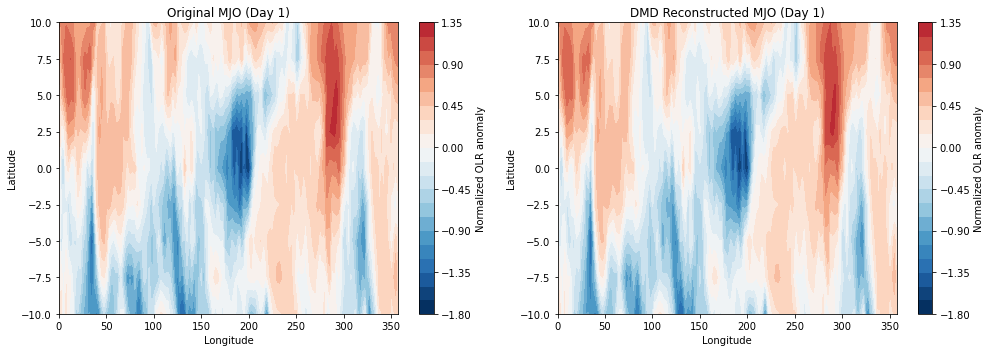

In [2]:

filename = "olr.nc"     
lat_min = -10           # Equatorial band for MJO
lat_max = 10
low_period = 30         # days
high_period = 90        # days
fs = 1                  # daily sampling
M = 31                  # Lanczos filter length
r = 244
r = 300                 # DMD truncation rank
day_idx = 1            # Day index for comparison 


#Load OLR

olr = xr.open_dataset(filename)['olr']  # shape: (time, lat, lon)
print("Original OLR shape:", olr.shape)


#Select equatorial band for -10N to 10N latitude where the presence of MJO is dominant

if olr.lat.values[0] > olr.lat.values[-1]:  # descending
    olr_eq = olr.sel(lat=slice(lat_max, lat_min))
else:  # ascending
    olr_eq = olr.sel(lat=slice(lat_min, lat_max))

lat_vals = olr_eq.lat.values
lon_vals = olr_eq.lon.values
time_vals = olr_eq.time.values
print("Equatorial latitudes selected:", lat_vals)


#Remove mean and normalize
#Z-score normalization method is used
olr_anom = olr_eq - olr_eq.mean(dim='time')
olr_norm = olr_anom / olr_anom.std(dim='time')


#Lanczos band-pass filter for 30–90 days period

def lanczos_bandpass(data, low_period, high_period, fs=1, M=31):
    omega_low = 2 * np.pi / high_period
    omega_high = 2 * np.pi / low_period
    n = np.arange(-(M-1)//2, (M-1)//2 + 1)
    h = ((omega_high/np.pi) * np.sinc(omega_high*n/np.pi) -
         (omega_low/np.pi) * np.sinc(omega_low*n/np.pi))
    w = 0.42 + 0.5*np.cos(2*np.pi*n/(M-1)) + 0.08*np.cos(4*np.pi*n/(M-1))
    h *= w
    h /= np.sum(h)

    def filt_1d(x):
        return np.convolve(x, h, mode='same')

    filtered = xr.apply_ufunc(
        filt_1d,
        data,
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True
    )
    return filtered

olr_mjo = lanczos_bandpass(olr_norm, low_period, high_period, fs, M)
print("Filtered OLR shape:", olr_mjo.shape)


#Reshape for DMD (space x time)

time_len = olr_mjo.sizes['time']
lat_len = olr_mjo.sizes['lat']
lon_len = olr_mjo.sizes['lon']
space_len = lat_len * lon_len

X = olr_mjo.values.reshape(lat_len*lon_len, time_len)  # space x time
print("Combined feature matrix shape:", X.shape)


#Construct X1, X2 for DMD

X1 = X[:, :-1]
X2 = X[:, 1:]


#SVD and low-rank DMD operator

U, S, Vh = svd(X1, full_matrices=False)
Ur = U[:, :r]
Sr = np.diag(S[:r])
Vr = Vh.conj().T[:, :r]
A_tilde = Ur.T @ X2 @ Vr @ np.linalg.inv(Sr)


#Eigen-decomposition

eigvals, W = eig(A_tilde)
Phi = X2 @ Vr @ np.linalg.inv(Sr) @ W  # DMD modes
omega = np.log(eigvals)


#Mode amplitudes and time dynamics

x0 = X1[:, 0]
b = np.linalg.lstsq(Phi, x0, rcond=None)[0]
time_vec = np.arange(time_len-1)
time_dynamics = np.zeros((r, time_len-1), dtype=complex)
for i in range(r):
    time_dynamics[i, :] = b[i] * np.exp(omega[i]*time_vec)


#DMD Reconstruction

X_dmd_reconstructed = (Phi @ time_dynamics).real  # space x time
reconstructed_olr = X_dmd_reconstructed.T.reshape(time_len-1, lat_len, lon_len)  # time x lat x lon
print("Reconstructed X shape:", X_dmd_reconstructed.shape)


#Prepare original MJO to match reconstruction

olr_mjo_timefirst = olr_mjo.values.transpose(2,0,1)  # time x lat x lon
olr_mjo_trunc = olr_mjo_timefirst[:time_len-1, :, :]  # truncate last time step


#Plot Original vs Reconstructed 

vlim = max(abs(olr_mjo_trunc[day_idx,:,:]).max(), abs(reconstructed_olr[day_idx,:,:]).max())
vmin, vmax = -vlim, vlim

plt.figure(figsize=(14,5))

# Original
plt.subplot(1,2,1)
plt.contourf(lon_vals, lat_vals, olr_mjo_trunc[day_idx,:,:],
             cmap='RdBu_r', levels=21, vmin=vmin, vmax=vmax)
plt.colorbar(label='Normalized OLR anomaly')
plt.title(f'Original MJO (Day {day_idx})')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Reconstructed
plt.subplot(1,2,2)
plt.contourf(lon_vals, lat_vals, reconstructed_olr[day_idx,:,:],
             cmap='RdBu_r', levels=21, vmin=vmin, vmax=vmax)
plt.colorbar(label='Normalized OLR anomaly')
plt.title(f'DMD Reconstructed MJO (Day {day_idx})')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()


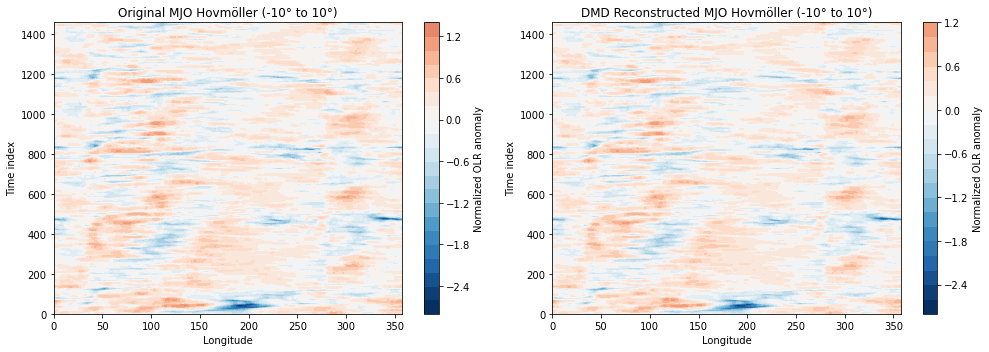

In [3]:
#Hovmöller plots for Original vs Reconstructed
#Each line is represents the average over the latitude from -10 to 10 degree North 
#at each longitute
# Select equatorial band indices (-10° to 10°)
equator_idx = (lat_vals >= -10) & (lat_vals <= 10)

# Average over latitude
hov_orig = olr_mjo_trunc[:, equator_idx, :].mean(axis=1)       # (time x lon)
hov_recon = reconstructed_olr[:, equator_idx, :].mean(axis=1)  # (time x lon)


vlim = max(abs(hov_orig).max(), abs(hov_recon).max())
plt.figure(figsize=(14,5))

# Original
plt.subplot(1,2,1)
plt.contourf(lon_vals, np.arange(time_len-1), hov_orig, cmap='RdBu_r', levels=21, vmin=-vlim, vmax=vlim)
plt.colorbar(label='Normalized OLR anomaly')
plt.xlabel('Longitude')
plt.ylabel('Time index')
plt.title('Original MJO Hovmöller (-10° to 10°)')

# Reconstructed
plt.subplot(1,2,2)
plt.contourf(lon_vals, np.arange(time_len-1), hov_recon, cmap='RdBu_r', levels=21, vmin=-vlim, vmax=vlim)
plt.colorbar(label='Normalized OLR anomaly')
plt.xlabel('Longitude')
plt.ylabel('Time index')
plt.title('DMD Reconstructed MJO Hovmöller (-10° to 10°)')

plt.tight_layout()
plt.show()


Here DMD is done to find out optimal rank by looping the r and determing its error metrics
and dominant pattern. For this cumulative energy method is used 99.99% energy.


NOTE: Here I am again redoing the previous steps also just to avoid the confusion while looping

Combined feature matrix shape: (1296, 1461)


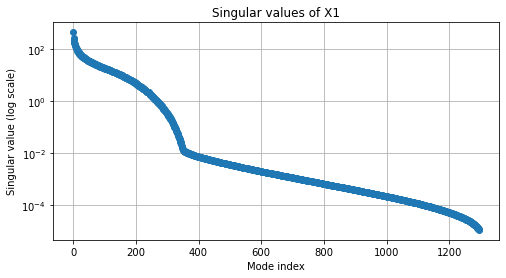

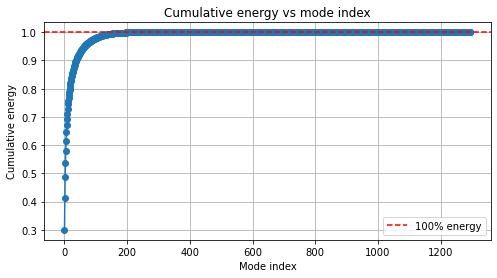

Optimal r (99.99% energy): 244


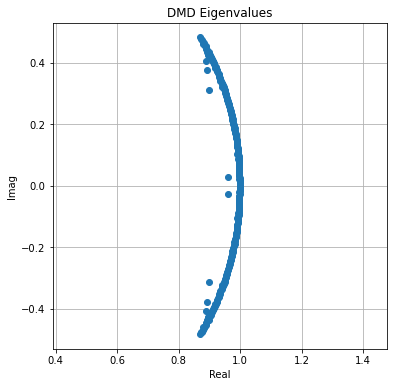

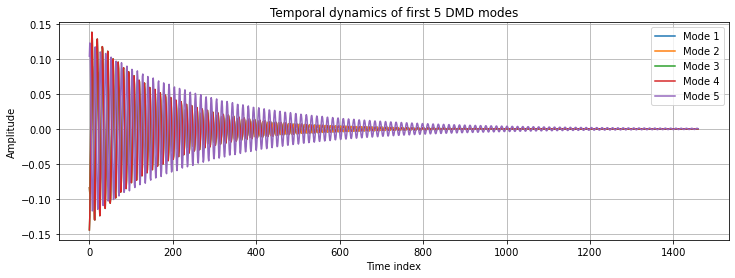

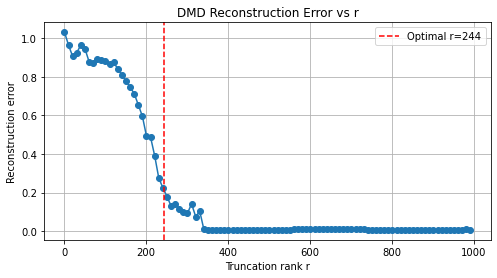

In [4]:

lat_min, lat_max = -10, 10
low_period, high_period = 30, 90    # days for MJO band
fs, M = 1, 31                       # sampling freq, Lanczos filter length
energy_threshold = 0.9999           # 99.99% energy for optimal r


# select equatorial band
# -----------------------------
olr = xr.open_dataset(filename)['olr']  # shape: (time, lat, lon)
if olr.lat.values[0] > olr.lat.values[-1]:
    olr_eq = olr.sel(lat=slice(lat_max, lat_min))
else:
    olr_eq = olr.sel(lat=slice(lat_min, lat_max))

lat_vals = olr_eq.lat.values
lon_vals = olr_eq.lon.values
time_vals = olr_eq.time.values


#Normalize anomalies

olr_anom = olr_eq - olr_eq.mean(dim='time')
olr_norm = olr_anom / olr_anom.std(dim='time')


# Lanczos band-pass filter

def lanczos_bandpass(data, low_period, high_period, fs=1, M=31):
    omega_low = 2*np.pi/high_period
    omega_high = 2*np.pi/low_period
    n = np.arange(-(M-1)//2, (M-1)//2 + 1)
    h = ((omega_high/np.pi)*np.sinc(omega_high*n/np.pi) -
         (omega_low/np.pi)*np.sinc(omega_low*n/np.pi))
    w = 0.42 + 0.5*np.cos(2*np.pi*n/(M-1)) + 0.08*np.cos(4*np.pi*n/(M-1))
    h *= w
    h /= np.sum(h)
    def filt_1d(x):
        return np.convolve(x, h, mode='same')
    filtered = xr.apply_ufunc(
        filt_1d,
        data,
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True
    )
    return filtered

olr_mjo = lanczos_bandpass(olr_norm, low_period, high_period, fs, M)


# Reshape for DMD

time_len = olr_mjo.sizes['time']
lat_len = olr_mjo.sizes['lat']
lon_len = olr_mjo.sizes['lon']
space_len = lat_len * lon_len

X = olr_mjo.values.reshape(lat_len*lon_len, time_len)  # space x time
X1 = X[:, :-1]
X2 = X[:, 1:]
print("Combined feature matrix shape:", X.shape)

#SVD

U, S, Vh = svd(X1, full_matrices=False)

# Singular values plot
plt.figure(figsize=(8,4))
plt.semilogy(S, 'o-')
plt.xlabel('Mode index')
plt.ylabel('Singular value (log scale)')
plt.title('Singular values of X1')
plt.grid(True)
plt.savefig("Figure2.jpg", format="jpg", dpi=300)
plt.show()

# Cumulative energy
energy = np.cumsum(S**2)/np.sum(S**2)
plt.figure(figsize=(8,4))
plt.plot(energy, 'o-')
plt.axhline(energy_threshold, color='r', linestyle='--', label=f'{energy_threshold*100:.0f}% energy')
plt.xlabel('Mode index')
plt.ylabel('Cumulative energy')
plt.title('Cumulative energy vs mode index')
plt.grid(True)
plt.legend()
plt.show()

# Determine optimal r
optimal_r = np.searchsorted(energy, energy_threshold) + 1
print(f"Optimal r (99.99% energy): {optimal_r}")


#Construct low-rank DMD operator

Ur = U[:, :optimal_r]
Sr = np.diag(S[:optimal_r])
Vr = Vh.conj().T[:, :optimal_r]
A_tilde = Ur.T @ X2 @ Vr @ np.linalg.inv(Sr)

# Eigen-decomposition
eigvals, W = eig(A_tilde)
Phi = X2 @ Vr @ np.linalg.inv(Sr) @ W
omega = np.log(eigvals)

# Plot DMD eigenvalues
plt.figure(figsize=(6,6))
plt.plot(eigvals.real, eigvals.imag, 'o')
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title('DMD Eigenvalues')
plt.grid(True)
plt.axis('equal')
plt.show()


# 7. Mode amplitudes and time dynamics

x0 = X1[:,0]
b = np.linalg.lstsq(Phi, x0, rcond=None)[0]
time_vec = np.arange(time_len-1)
time_dynamics = np.zeros((optimal_r, time_len-1), dtype=complex)
for i in range(optimal_r):
    time_dynamics[i,:] = b[i] * np.exp(omega[i]*time_vec)

# Plot temporal dynamics for first 5 modes
plt.figure(figsize=(12,4))
for i in range(min(5, optimal_r)):
    plt.plot(time_vec, time_dynamics[i,:].real, label=f'Mode {i+1}')
plt.xlabel('Time index')
plt.ylabel('Amplitude')
plt.title('Temporal dynamics of first 5 DMD modes')
plt.legend()
plt.grid(True)
plt.savefig("Figure4.jpg", format="jpg", dpi=300)
plt.show()


# Reconstruction error as a function of r

max_r = min(1000, X1.shape[0])
errors = []
r_list = np.arange(1, max_r+1, 10)
for r_try in r_list:
    Ur_r = U[:, :r_try]
    Sr_r = np.diag(S[:r_try])
    Vr_r = Vh.conj().T[:, :r_try]
    A_tilde_r = Ur_r.T @ X2 @ Vr_r @ np.linalg.inv(Sr_r)
    eigvals_r, W_r = eig(A_tilde_r)
    Phi_r = X2 @ Vr_r @ np.linalg.inv(Sr_r) @ W_r
    b_r = np.linalg.lstsq(Phi_r, X1[:,0], rcond=None)[0]
    time_dynamics_r = np.zeros((r_try, time_len-1), dtype=complex)
    for i in range(r_try):
        time_dynamics_r[i,:] = b_r[i]*np.exp(np.log(eigvals_r[i])*time_vec)
    X_recon_r = (Phi_r @ time_dynamics_r).real
    err = np.linalg.norm(X1 - X_recon_r)/np.linalg.norm(X1)
    errors.append(err)

plt.figure(figsize=(8,4))
plt.plot(r_list, errors, 'o-')
plt.axvline(optimal_r, color='r', linestyle='--', label=f'Optimal r={optimal_r}')
plt.xlabel('Truncation rank r')
plt.ylabel('Reconstruction error')
plt.title('DMD Reconstruction Error vs r')
plt.grid(True)
plt.legend()
plt.show()


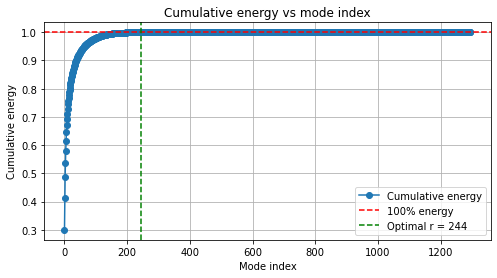

In [5]:
# Cumulative energy
energy = np.cumsum(S**2)/np.sum(S**2)
plt.figure(figsize=(8,4))
plt.plot(energy, 'o-', label='Cumulative energy')
plt.axhline(energy_threshold, color='r', linestyle='--', label=f'{energy_threshold*100:.0f}% energy')
plt.axvline(optimal_r-1, color='g', linestyle='--', label=f'Optimal r = {optimal_r}')
plt.xlabel('Mode index')
plt.ylabel('Cumulative energy')
plt.title('Cumulative energy vs mode index')
plt.grid(True)
plt.legend()
plt.savefig("Figure3.jpg", format="jpg", dpi=300)
plt.show()


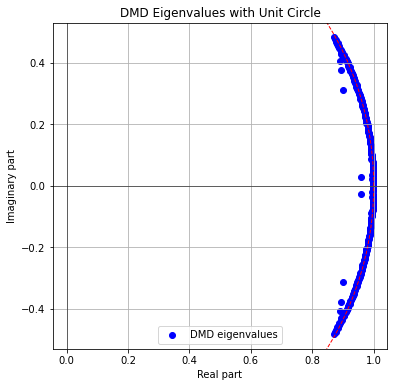

In [6]:
# DMD eigenvalues plot
plt.figure(figsize=(6,6))
plt.scatter(eigvals.real, eigvals.imag, color='b', label='DMD eigenvalues')
circle = plt.Circle((0,0), 1, color='r', fill=False, linestyle='--', label='Unit circle')
plt.gca().add_artist(circle)

plt.axhline(0, color='k', linewidth=0.5)
plt.axvline(0, color='k', linewidth=0.5)
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.title('DMD Eigenvalues with Unit Circle')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.savefig("Figure5.jpg", format="jpg", dpi=300)
plt.show()


Here the reconstruction error for different 

Optimal r (99.99% energy): 244

Reconstruction errors for different r (using Frobenius norm):
r	Error
1	1.03101
11	0.96334
21	0.90534
31	0.92518
41	0.96572
51	0.94466
61	0.87834
71	0.87221
81	0.89039
91	0.88799
101	0.88440
111	0.86432
121	0.87666
131	0.83986
141	0.80990
151	0.77745
161	0.74669
171	0.71306
181	0.65512
191	0.59553
201	0.49281
211	0.48702
221	0.39063
231	0.27530
241	0.22440
251	0.17931
261	0.13062
271	0.14162
281	0.11674
291	0.10162
301	0.09242
311	0.14119
321	0.07555
331	0.10259
341	0.00899
351	0.00628
361	0.00696
371	0.00702
381	0.00686
391	0.00658
401	0.00685
411	0.00663
421	0.00697
431	0.00728
441	0.00652
451	0.00645
461	0.00646
471	0.00675
481	0.00639
491	0.00654
501	0.00618
511	0.00634
521	0.00645
531	0.00659
541	0.00729
551	0.00810
561	0.00840
571	0.00928
581	0.01008
591	0.00890
601	0.01027
611	0.00954
621	0.00916
631	0.01196
641	0.01072
651	0.01256
661	0.01258
671	0.00966
681	0.01137
691	0.01078
701	0.01223
711	0.01229
721	0.01307
731	0.00862
741	0.00756
751	0.007

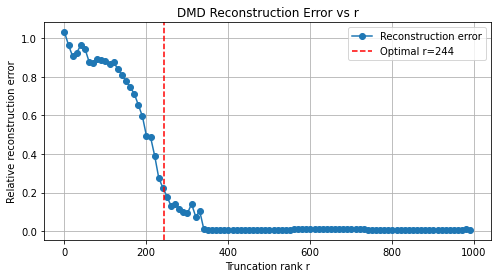


Reconstruction error formula used:
Error = ||X1 - X_reconstructed||_F / ||X1||_F
Where ||.||_F is the Frobenius norm of the matrix.


In [7]:

# Compute cumulative energy and optimal r (99% energy)
cumulative_energy = np.cumsum(S**2) / np.sum(S**2)
optimal_r = np.searchsorted(cumulative_energy, 0.9999) + 1
print(f"Optimal r (99.99% energy): {optimal_r}")

# Compute reconstruction error vs r
max_r = min(1000, X1.shape[0])
r_list = np.arange(1, max_r+1, 10)
errors = []

print("\nReconstruction errors for different r (using Frobenius norm):")
print("r\tError")
for r_try in r_list:
    Ur_r = U[:, :r_try]
    Sr_r = np.diag(S[:r_try])
    Vr_r = Vh.conj().T[:, :r_try]
    
    # Reduced DMD operator
    A_tilde_r = Ur_r.T @ X2 @ Vr_r @ np.linalg.inv(Sr_r)
    
    # Eigen-decomposition
    eigvals_r, W_r = eig(A_tilde_r)
    Phi_r = X2 @ Vr_r @ np.linalg.inv(Sr_r) @ W_r
    
    # Mode amplitudes
    b_r = np.linalg.lstsq(Phi_r, X1[:,0], rcond=None)[0]
    
    # Time dynamics
    time_dynamics_r = np.zeros((r_try, time_len-1), dtype=complex)
    for i in range(r_try):
        time_dynamics_r[i, :] = b_r[i] * np.exp(np.log(eigvals_r[i]) * time_vec)
    
    # Reconstruction
    X_recon_r = (Phi_r @ time_dynamics_r).real
    
    # Relative Frobenius norm error
    err = np.linalg.norm(X1 - X_recon_r) / np.linalg.norm(X1)
    errors.append(err)
    
    print(f"{r_try}\t{err:.5f}")


# Plot reconstruction error vs r

plt.figure(figsize=(8,4))
plt.plot(r_list, errors, 'o-', label='Reconstruction error')
plt.axvline(optimal_r, color='r', linestyle='--', label=f'Optimal r={optimal_r}')
plt.xlabel('Truncation rank r')
plt.ylabel('Relative reconstruction error')
plt.title('DMD Reconstruction Error vs r')
plt.grid(True)
plt.legend()
plt.savefig("Figure6.jpg", format="jpg", dpi=300)
plt.show()

# Reconstruction error equation

print("\nReconstruction error formula used:")
print("Error = ||X1 - X_reconstructed||_F / ||X1||_F")
print("Where ||.||_F is the Frobenius norm of the matrix.")


Optimal r for 99.99% energy: 244


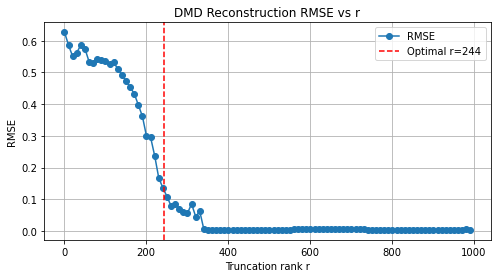

r	RMSE
1	0.62679
11	0.58565
21	0.55039
31	0.56245
41	0.58709
51	0.57429
61	0.53398
71	0.53025
81	0.54130
91	0.53984
101	0.53766
111	0.52545
121	0.53295
131	0.51058
141	0.49237
151	0.47264
161	0.45394
171	0.43349
181	0.39827
191	0.36204
201	0.29960
211	0.29607
221	0.23747
231	0.16736
241	0.13642
251	0.10901
261	0.07941
271	0.08610
281	0.07097
291	0.06178
301	0.05619
311	0.08583
321	0.04593
331	0.06237
341	0.00546
351	0.00382
361	0.00423
371	0.00427
381	0.00417
391	0.00400
401	0.00416
411	0.00403
421	0.00423
431	0.00443
441	0.00396
451	0.00392
461	0.00393
471	0.00410
481	0.00389
491	0.00398
501	0.00376
511	0.00386
521	0.00392
531	0.00401
541	0.00443
551	0.00493
561	0.00511
571	0.00564
581	0.00613
591	0.00541
601	0.00625
611	0.00580
621	0.00557
631	0.00727
641	0.00652
651	0.00764
661	0.00765
671	0.00587
681	0.00691
691	0.00655
701	0.00744
711	0.00747
721	0.00794
731	0.00524
741	0.00460
751	0.00455
761	0.00431
771	0.00407
781	0.00392
791	0.00395
801	0.00413
811	0.00422
821	0.00410
831	0.00

In [8]:
#HERE RMSE is calulated

time_len = X1.shape[1] + 1
time_vec = np.arange(time_len-1)

# --- Determine optimal r based on 99% energy
cumulative_energy = np.cumsum(S**2) / np.sum(S**2)
optimal_r = np.searchsorted(cumulative_energy, 0.9999) + 1
print("Optimal r for 99.99% energy:", optimal_r)

#  Compute RMSE for different r
max_r = min(1000, X1.shape[0])
r_list = np.arange(1, max_r+1, 10)
rmse_list = []

for r_try in r_list:
    Ur_r = U[:, :r_try]
    Sr_r = np.diag(S[:r_try])
    Vr_r = Vh.conj().T[:, :r_try]
    
    A_tilde_r = Ur_r.T @ X2 @ Vr_r @ np.linalg.inv(Sr_r)
    eigvals_r, W_r = eig(A_tilde_r)
    Phi_r = X2 @ Vr_r @ np.linalg.inv(Sr_r) @ W_r
    
    b_r = np.linalg.lstsq(Phi_r, X1[:,0], rcond=None)[0]
    
    time_dynamics_r = np.zeros((r_try, time_len-1), dtype=complex)
    for i in range(r_try):
        time_dynamics_r[i, :] = b_r[i] * np.exp(np.log(eigvals_r[i]) * time_vec)
    
    X_recon_r = (Phi_r @ time_dynamics_r).real
    rmse = np.sqrt(np.mean((X1 - X_recon_r)**2))
    rmse_list.append(rmse)

#  Plot RMSE vs r
plt.figure(figsize=(8,4))
plt.plot(r_list, rmse_list, 'o-', label='RMSE')
plt.axvline(optimal_r, color='r', linestyle='--', label=f'Optimal r={optimal_r}')
plt.xlabel('Truncation rank r')
plt.ylabel('RMSE')
plt.title('DMD Reconstruction RMSE vs r')
plt.grid(True)
plt.legend()
plt.show()

#  Print RMSE table
print("r\tRMSE")
for r_val, err in zip(r_list, rmse_list):
    print(f"{r_val}\t{err:.5f}")


<Figure size 1008x360 with 0 Axes>

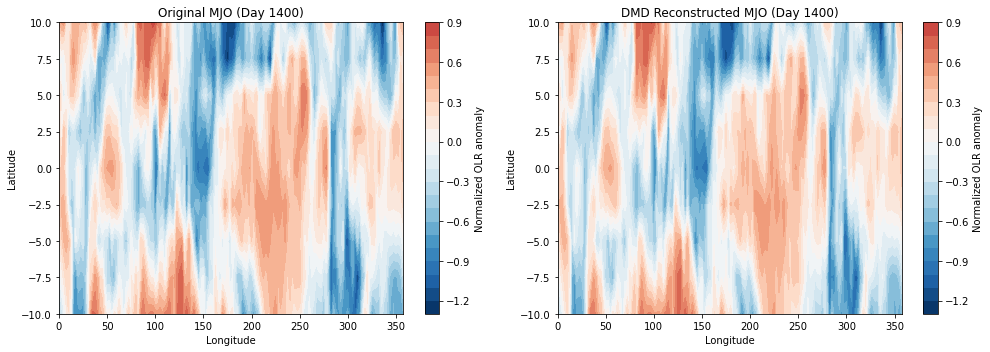

In [9]:

# Spatial comparison (Original vs Reconstructed)
# For any single day
# NOte here r = 300 which is different from optimal r=244
day_idx = 1400  # pick the day index



vlim = max(
    abs(olr_mjo_trunc[day_idx,:,:]).max(),
    abs(reconstructed_olr[day_idx,:,:]).max()
)

plt.figure(figsize=(14,5))


plt.figure(figsize=(14,5))

# Original MJO
plt.subplot(1,2,1)
plt.contourf(lon_vals, lat_vals, olr_mjo_trunc[day_idx,:,:],
             cmap='RdBu_r', levels=21, vmin=-vlim, vmax=vlim)
plt.colorbar(label='Normalized OLR anomaly')
plt.title(f'Original MJO (Day {day_idx})')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# DMD Reconstructed MJO
plt.subplot(1,2,2)
plt.contourf(lon_vals, lat_vals, reconstructed_olr[day_idx,:,:],
             cmap='RdBu_r', levels=21, vmin=-vlim, vmax=vlim)
plt.colorbar(label='Normalized OLR anomaly')
plt.title(f'DMD Reconstructed MJO (Day {day_idx})')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()


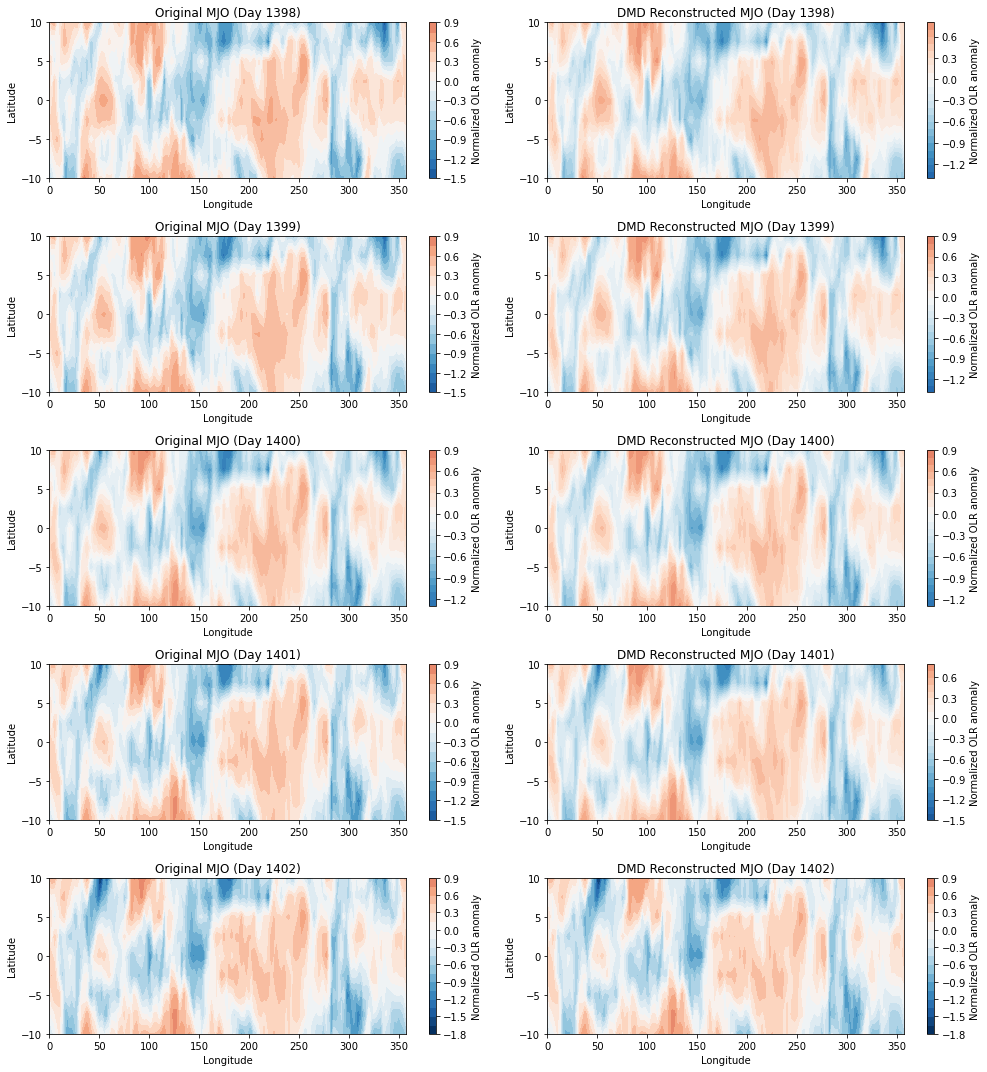

In [10]:

# Spatial comparison (Original vs Reconstructed) for multiple days
# Here mostly I used end days for reconstruction

days_to_plot = [1398, 1399, 1400, 1401, 1402]  # list of day indices
num_days = len(days_to_plot)


vlim = max(
    max(abs(olr_mjo_trunc[d,:,:]).max() for d in days_to_plot),
    max(abs(reconstructed_olr[d,:,:]).max() for d in days_to_plot)
)

plt.figure(figsize=(14, 3*num_days))

for i, day_idx in enumerate(days_to_plot):
    # Original MJO
    plt.subplot(num_days, 2, 2*i + 1)
    plt.contourf(lon_vals, lat_vals, olr_mjo_trunc[day_idx,:,:],
                 cmap='RdBu_r', levels=21, vmin=-vlim, vmax=vlim)
    plt.colorbar(label='Normalized OLR anomaly')
    plt.title(f'Original MJO (Day {day_idx})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    # DMD Reconstructed MJO
    plt.subplot(num_days, 2, 2*i + 2)
    plt.contourf(lon_vals, lat_vals, reconstructed_olr[day_idx,:,:],
                 cmap='RdBu_r', levels=21, vmin=-vlim, vmax=vlim)
    plt.colorbar(label='Normalized OLR anomaly')
    plt.title(f'DMD Reconstructed MJO (Day {day_idx})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

plt.tight_layout()
plt.savefig("Figure7.jpg", format="jpg", dpi=300)
plt.show()


Here HOVMOLLER plot is created for southwest monsoon period of 2013( 1st Jun 2013 to 30th Sep 2013)

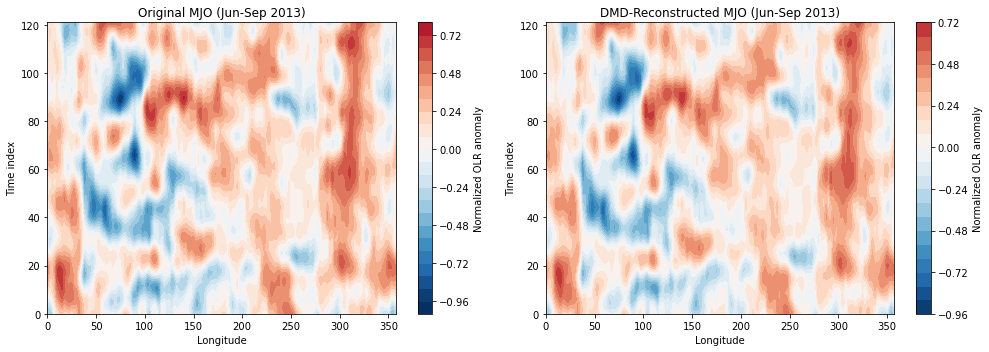

In [11]:

# Time indices for Jun-Sep 2013

time_index_full = (time_vals >= np.datetime64('2013-06-01')) & (time_vals <= np.datetime64('2013-09-30'))

# Original OLR times
time_sel_orig = time_vals[time_index_full]

# DMD reconstruction times (truncate last time step)
time_vals_dmd = time_vals[:-1]
time_index_dmd = time_index_full[:-1]
time_sel_dmd = time_vals_dmd[time_index_dmd]

# -----------------------------
# Original MJO
olr_mjo_timefirst = olr_mjo.values.transpose(2,0,1)  # time x lat x lon
olr_sel = olr_mjo_timefirst[time_index_full, :, :]

# DMD reconstructed
reconstructed_sel = reconstructed_olr[time_index_dmd, :, :]

# Equatorial mean (-10° to 10°)
equator_idx = (lat_vals >= -10) & (lat_vals <= 10)
hov_orig = olr_sel[:, equator_idx, :].mean(axis=1)
hov_dmd  = reconstructed_sel[:, equator_idx, :].mean(axis=1)


vlim = max(abs(hov_orig.min()), abs(hov_orig.max()),
           abs(hov_dmd.min()), abs(hov_dmd.max()))

# Plot Hovmoller 
fig, axes = plt.subplots(1, 2, figsize=(14,5))

cf1 = axes[0].contourf(lon_vals, np.arange(len(time_sel_orig)), hov_orig,
                       levels=21, cmap='RdBu_r', vmin=-vlim, vmax=vlim)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Time index')
axes[0].set_title('Original MJO (Jun-Sep 2013)')
fig.colorbar(cf1, ax=axes[0], label='Normalized OLR anomaly')

cf2 = axes[1].contourf(lon_vals, np.arange(len(time_sel_dmd)), hov_dmd,
                       levels=21, cmap='RdBu_r', vmin=-vlim, vmax=vlim)
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Time index')
axes[1].set_title('DMD-Reconstructed MJO (Jun-Sep 2013)')
fig.colorbar(cf2, ax=axes[1], label='Normalized OLR anomaly')

plt.tight_layout()
plt.savefig("Figure8.jpg", format="jpg", dpi=300)
plt.show()



Here FORECAST for next seven days is done using the calulated DMD patterns

NOTE: HERE only 1453 time steps of OLR is used (OUT of 1460). Last seven time steps are
used in the FORECAST

300


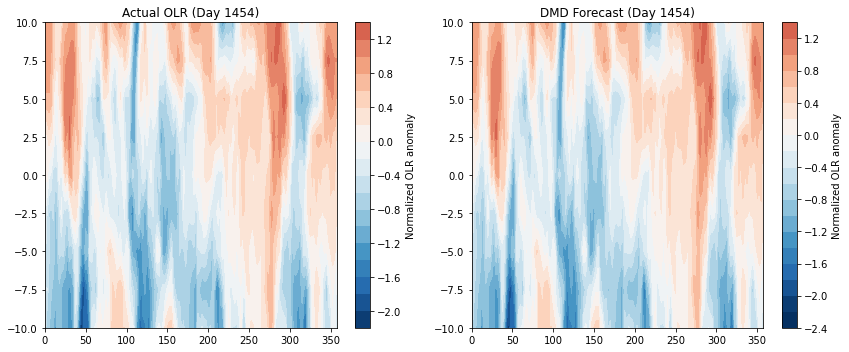

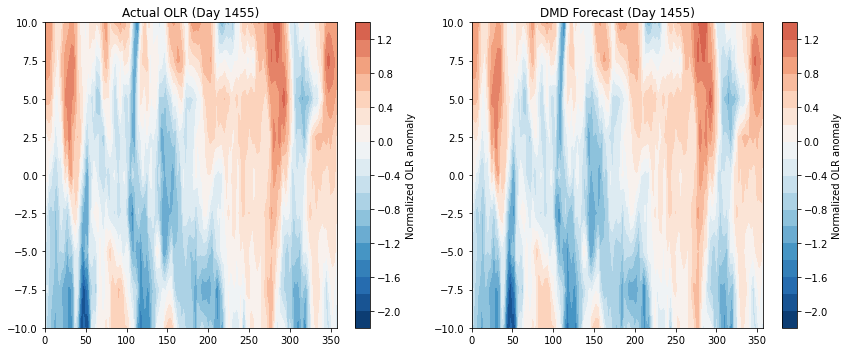

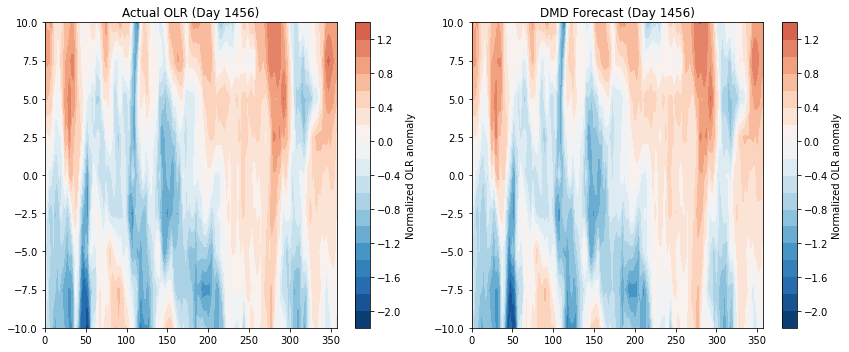

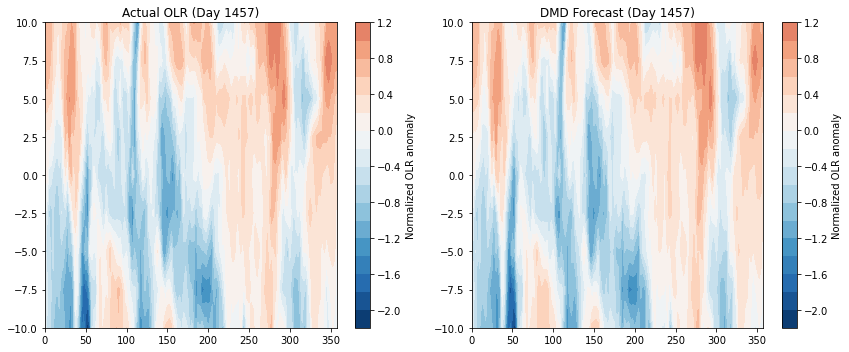

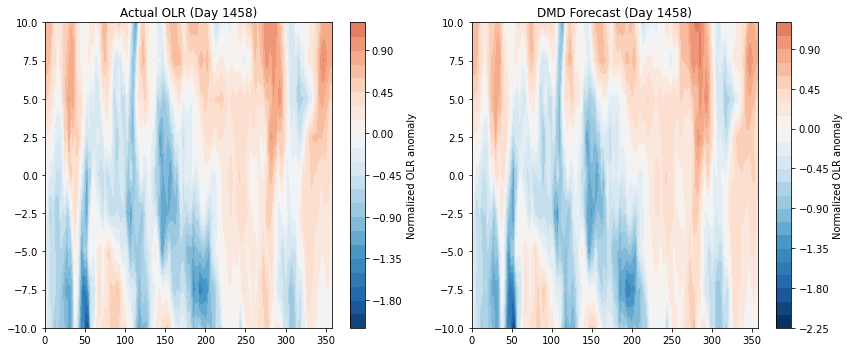

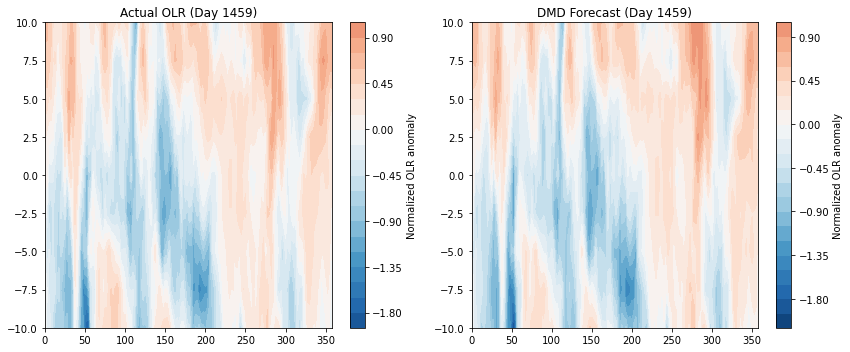

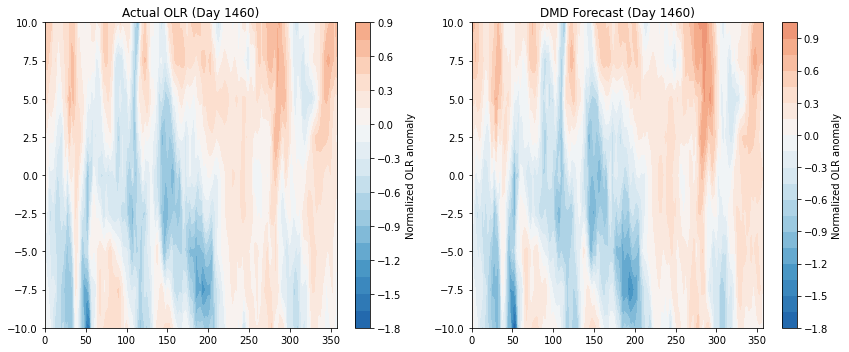

7-day forecast RMSE (normalized): 0.05248


In [12]:

#DMD Forecast for next 7 days

forecast_days = 7
print(r)
# Use training data excluding last 7 days
X_train = X[:, :-forecast_days]  # space x time
X1_train = X_train[:, :-1]
X2_train = X_train[:, 1:]

# SVD on training data
U_train, S_train, Vh_train = svd(X1_train, full_matrices=False)

# Use same truncation rank as before
Ur_train = U_train[:, :r]
Sr_train = np.diag(S_train[:r])
Vr_train = Vh_train.conj().T[:, :r]

# Low-rank DMD operator
A_tilde_train = Ur_train.T @ X2_train @ Vr_train @ np.linalg.inv(Sr_train)
eigvals_train, W_train = eig(A_tilde_train)
Phi_train = X2_train @ Vr_train @ np.linalg.inv(Sr_train) @ W_train
omega_train = np.log(eigvals_train)

# Initial condition: last column of X_train
x0_train = X_train[:, -1]
b_train = np.linalg.lstsq(Phi_train, x0_train, rcond=None)[0]

# Time vector for forecast
time_vec_forecast = np.arange(1, forecast_days + 1)

# Forecast dynamics
time_dynamics_forecast = np.zeros((r, forecast_days), dtype=complex)
for i in range(r):
    time_dynamics_forecast[i, :] = b_train[i] * np.exp(omega_train[i] * time_vec_forecast)

# Forecast reconstruction
X_dmd_forecast = (Phi_train @ time_dynamics_forecast).real  # space x forecast_days
forecast_olr = X_dmd_forecast.T.reshape(forecast_days, lat_len, lon_len)  # time x lat x lon


#Prepare actual OLR for forecast comparison
# -----------------------------
X_forecast_actual = X[:, -forecast_days:]  # last 7 days

#  normalized in olr_norm
forecast_actual_norm = X_forecast_actual.T.reshape(forecast_days, lat_len, lon_len)


# Plot forecast vs actual
# -----------------------------
for i in range(forecast_days):
   
    vlim = max(abs(forecast_actual_norm.min()), abs(forecast_actual_norm.max()), abs(forecast_olr.min()), abs(forecast_olr.max()))
    plt.figure(figsize=(12,5))
    # Actual
    plt.subplot(1,2,1)
    plt.contourf(lon_vals, lat_vals, forecast_actual_norm[i,:,:],
                 cmap='RdBu_r', levels=21, vmin=-vlim, vmax=vlim)
    plt.colorbar(label='Normalized OLR anomaly')
    plt.title(f'Actual OLR (Day {time_len - forecast_days + i})')
    
    # DMD forecast
    plt.subplot(1,2,2)
    plt.contourf(lon_vals, lat_vals, forecast_olr[i,:,:],
                 cmap='RdBu_r', levels=21, vmin=-vlim, vmax=vlim)
    plt.colorbar(label='Normalized OLR anomaly')
    plt.title(f'DMD Forecast (Day {time_len - forecast_days + i})')
    
    plt.tight_layout()
    #plt.savefig("Figure9.jpg", format="jpg", dpi=300)
    #plt.show()
    plt.savefig(f"Figure9_day{i+1}.jpg", format="jpg", dpi=300)
    plt.show()

#  Forecast RMSE

rmse_forecast = np.sqrt(np.mean((forecast_actual_norm - forecast_olr)**2))
print(f"7-day forecast RMSE (normalized): {rmse_forecast:.5f}")


Forecast error metrics 

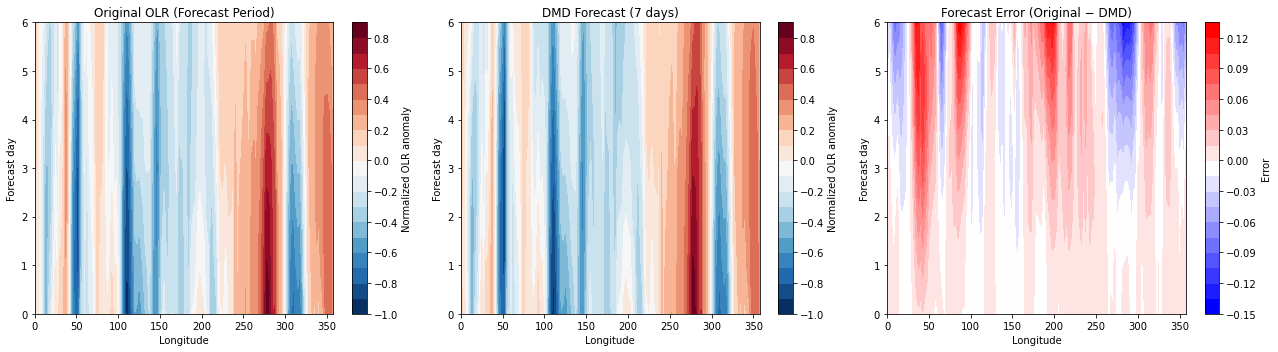

In [13]:
# Equatorial indices (all latitudes in the equatorial band)
equator_idx = np.arange(olr_mjo_timefirst.shape[1])  # all 9 latitudes

# Original MJO for forecast period (last 7 days)
hov_orig_forecast = olr_mjo_timefirst[-forecast_days:, equator_idx, :].mean(axis=1)  # shape: (7, lon)

# DMD forecast MJO
hov_dmd_forecast = forecast_olr[:, equator_idx, :].mean(axis=1)  # shape: (7, lon)

forecast_error = hov_orig_forecast - hov_dmd_forecast

vmin_orig = hov_orig_forecast.min()
vmax_orig = hov_orig_forecast.max()

vmin_dmd = hov_dmd_forecast.min()
vmax_dmd = hov_dmd_forecast.max()

vmin_err = forecast_error.min()
vmax_err = forecast_error.max()


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original OLR
cf0 = axes[0].contourf(lon_vals, np.arange(forecast_days), hov_orig_forecast,
                       levels=21, cmap='RdBu_r', vmin=vmin_orig, vmax=vmax_orig)
axes[0].set_title('Original OLR (Forecast Period)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Forecast day')
plt.colorbar(cf0, ax=axes[0], label='Normalized OLR anomaly')

# DMD Forecast
cf1 = axes[1].contourf(lon_vals, np.arange(forecast_days), hov_dmd_forecast,
                       levels=21, cmap='RdBu_r', vmin=vmin_dmd, vmax=vmax_dmd)
axes[1].set_title('DMD Forecast (7 days)')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Forecast day')
plt.colorbar(cf1, ax=axes[1], label='Normalized OLR anomaly')

# Forecast Error
cf2 = axes[2].contourf(lon_vals, np.arange(forecast_days), forecast_error,
                       levels=21, cmap='bwr', vmin=vmin_err, vmax=vmax_err)
axes[2].set_title('Forecast Error (Original − DMD)')
axes[2].set_xlabel('Longitude')
axes[2].set_ylabel('Forecast day')
plt.colorbar(cf2, ax=axes[2], label='Error')

plt.tight_layout()
plt.savefig("Figure10.jpg", format="jpg", dpi=300)
plt.show()
